In [193]:
!pip install scanpy

python(71313) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [194]:
import scanpy as sc
import datasets

In [195]:
!pip install scikit-misc
!pip install grelu

python(71315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(71317) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [196]:
import skmisc
import grelu
from grelu.sequence.utils import get_unique_length
from grelu.sequence.format import convert_input_type

In [197]:
# from google.colab import drive
# drive.mount('/content/drive')

In [198]:
# !ls /content/drive/My\ Drive/MSRP-Bio\ 2025/data

In [199]:
adata_atac = sc.read_h5ad('10x-Multiome-Pbmc10k-ATAC.h5ad')

adata_rna =  sc.read_h5ad('10x-Multiome-Pbmc10k-RNA.h5ad')

In [200]:
sc.pp.normalize_total(adata_rna, inplace=True)
sc.pp.log1p(adata_rna)
sc.pp.highly_variable_genes(adata_rna, n_top_genes=2000, subset=True)


In [201]:
adata_rna

AnnData object with n_obs × n_vars = 9631 × 2000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

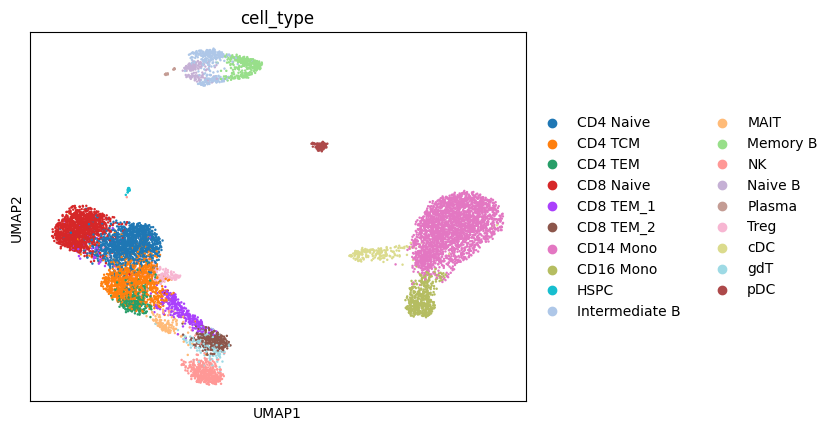

In [202]:
import scanpy as sc

sc.pp.pca(adata_rna, n_comps=50)

sc.pp.neighbors(adata_rna)

sc.tl.umap(adata_rna)

sc.pl.umap(adata_rna, color=['cell_type'])

In [203]:
sc.pp.highly_variable_genes(adata_atac, n_top_genes=1000, subset=True, flavor='seurat_v3')

In [204]:
adata_atac

AnnData object with n_obs × n_vars = 9631 × 1000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [205]:
peak_df = adata_atac.var

# new_peak_df = peak_df.drop(columns=['feature_types', 'genome', 'n_counts'] ).reset_index(drop=True)
new_peak_df = peak_df.drop(columns=['feature_types', 'genome', 'n_counts'] )

new_peak_df.rename(columns={'chromStart': 'start', 'chromEnd': 'end'}, inplace=True)

new_peak_df = new_peak_df[new_peak_df['chrom'].str.startswith('chr')]

# Filter peaks longer than 1024bp
new_peak_df = new_peak_df[new_peak_df['end'] - new_peak_df['start'] < 1024]

input_sequence = grelu.sequence.format.intervals_to_strings(new_peak_df, genome='hg38')

In [206]:
adata_atac = adata_atac[:, new_peak_df.index].copy()

In [207]:
adata_atac

AnnData object with n_obs × n_vars = 9631 × 536
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [208]:
import numpy as np

# Get unique cell types excluding CD14+ Monocytes
# cell_types = [ct for ct in adata_rna.obs['cell_type'].unique() if ct != 'CD14 Mono']
# n_types = len(cell_types)

# Get unique cell types
cell_types = [ct for ct in adata_rna.obs['cell_type'].unique()]
n_types = len(cell_types)

# Split cell types into train/valid/test (80/10/10)
n_train = int(0.8 * n_types)
n_valid = int(0.1 * n_types)

# Shuffle cell types
np.random.shuffle(cell_types)

# Split cell types
train_types = cell_types[:n_train]
valid_types = cell_types[n_train:n_train+n_valid]
test_types = cell_types[n_train+n_valid:]

In [209]:
print(len(train_types))
print(len(valid_types))
print(len(test_types))

15
1
3


Modification - Peak Property as Label, Pseudo Bulk Expression as Prompt

In [210]:
# DEP
sc.tl.rank_genes_groups(adata_atac, groupby='cell_type', method='wilcoxon', use_raw = False, key_added='rank_peaks_groups')

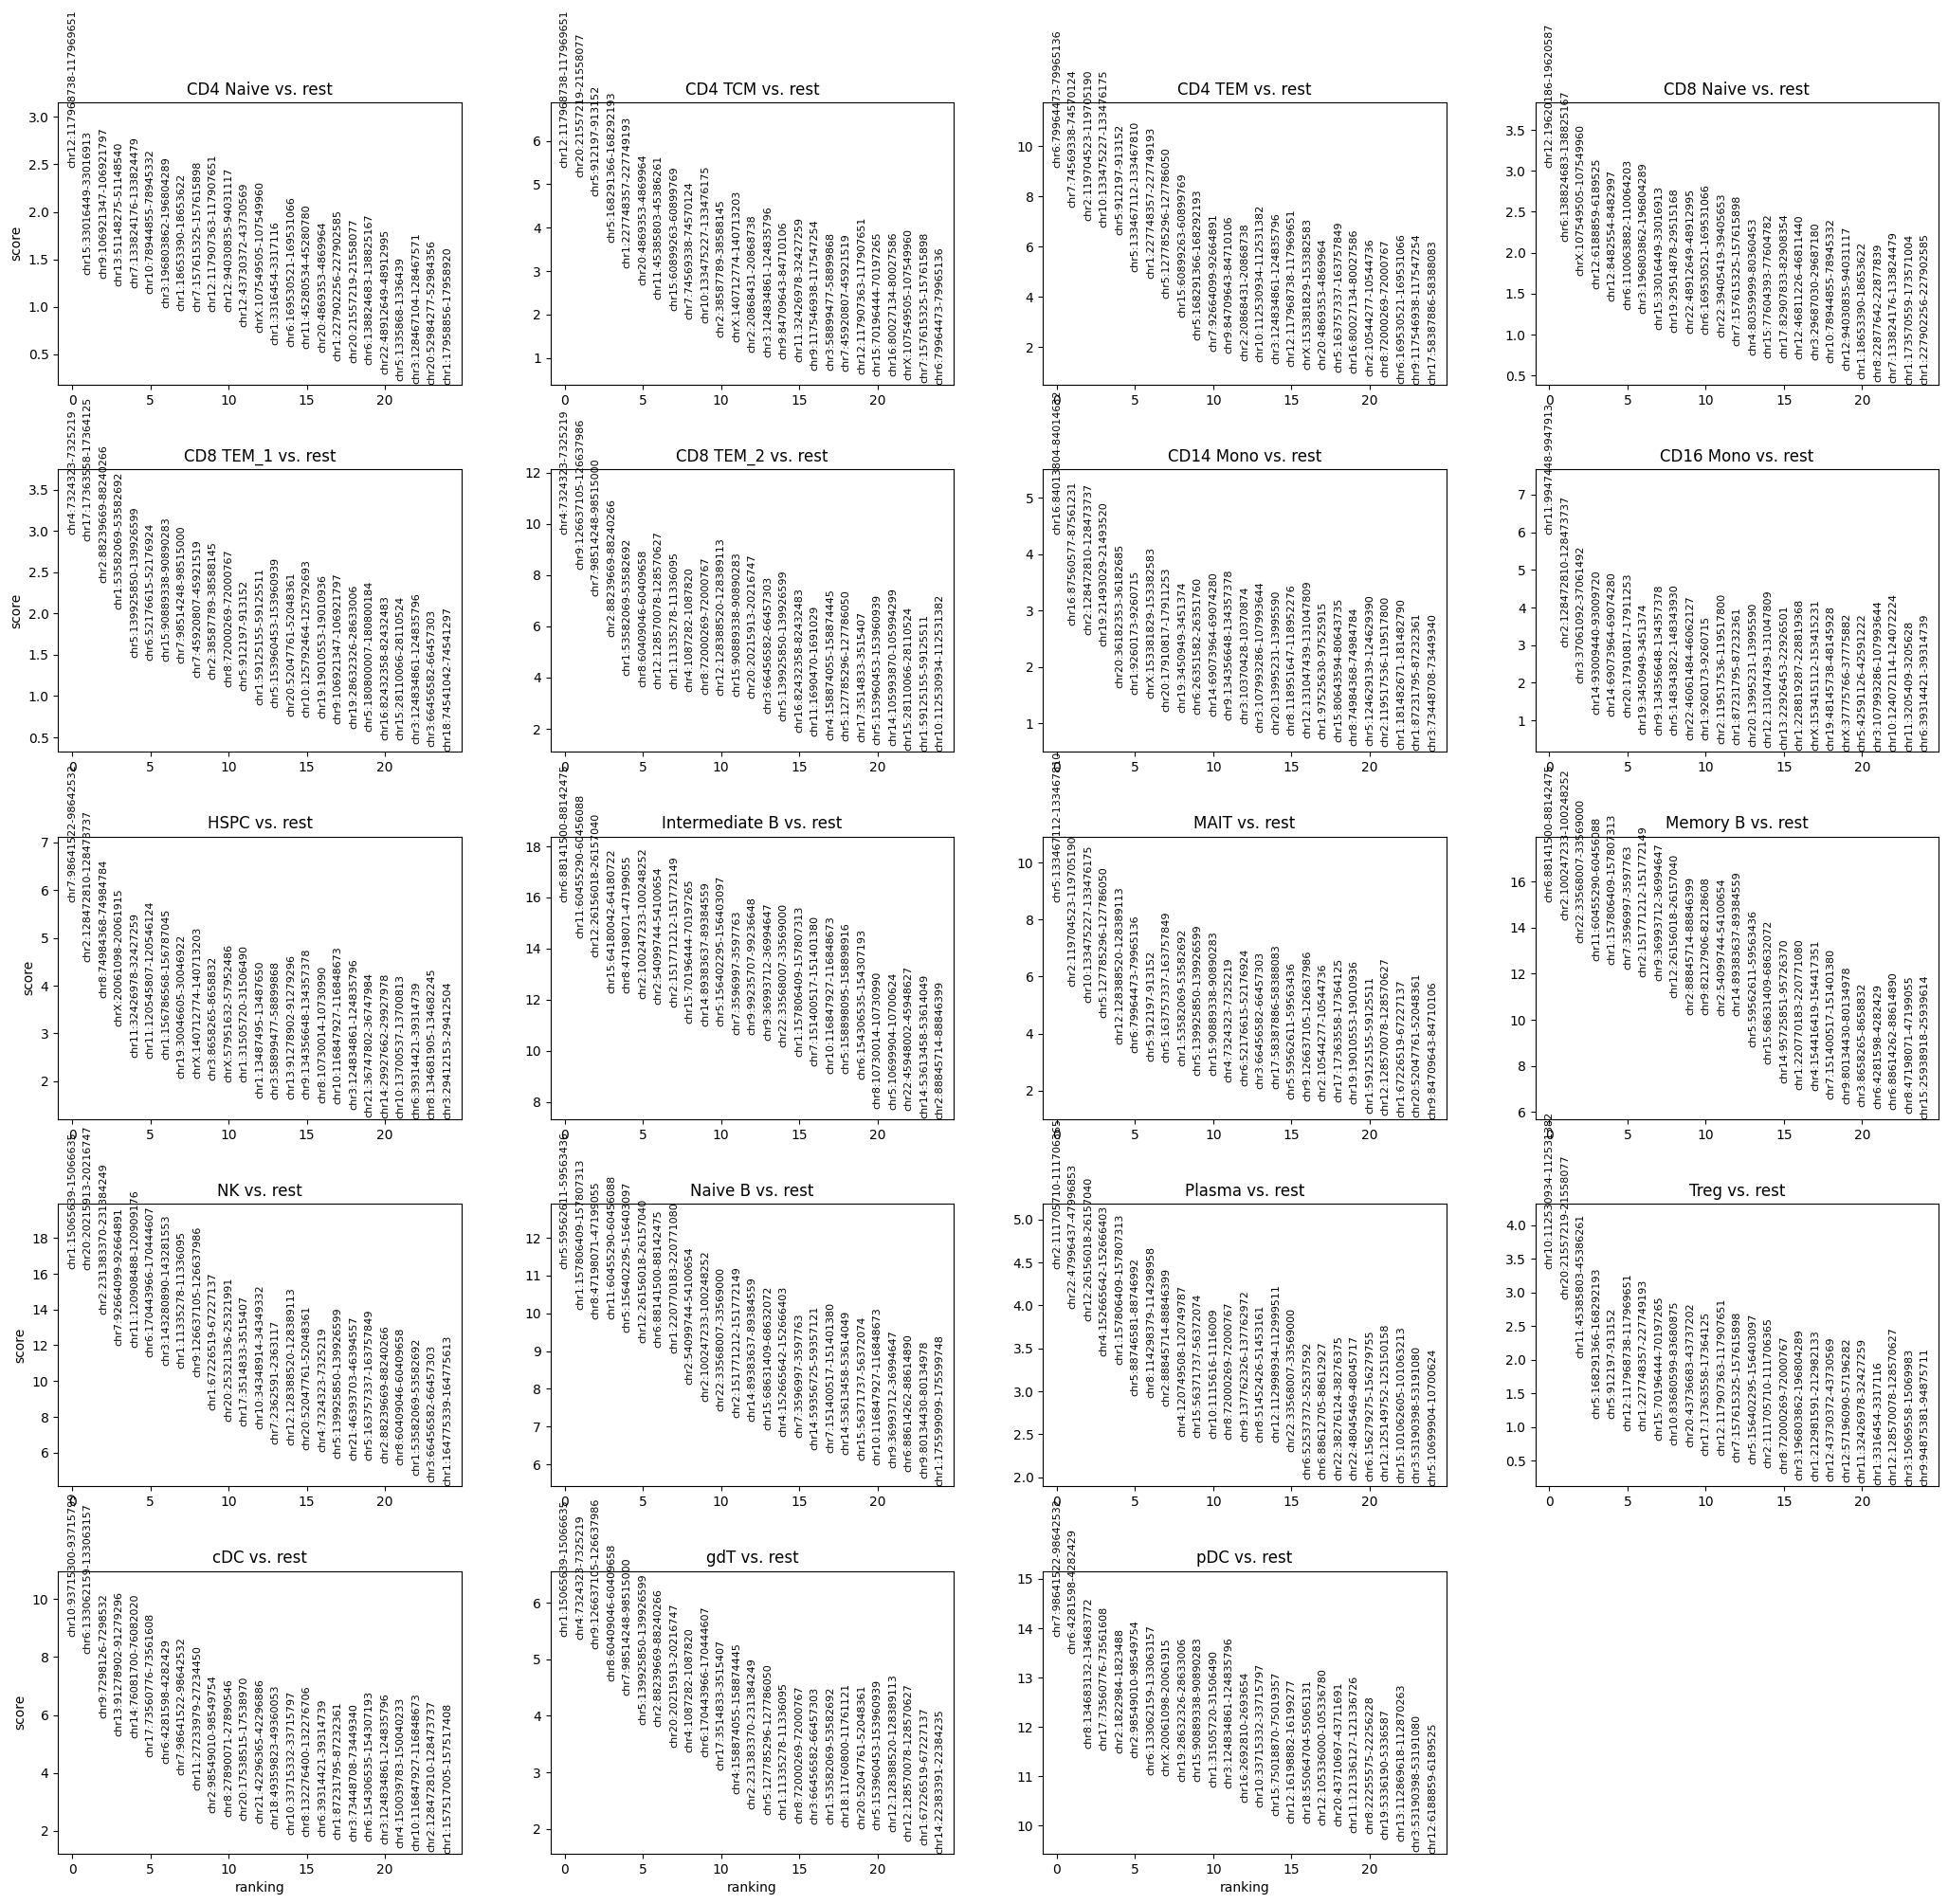

In [211]:
sc.pl.rank_genes_groups(adata_atac, n_genes=25, key = 'rank_peaks_groups', sharey=False, save='_rank_peaks.png')

In [212]:
import pandas as pd

n_markers_per_type = 25 # STATICALLY CHOOSE AMOUNT
marker_peaks_dict = {}

if 'rank_peaks_groups' in adata_atac.uns:
    ranked_peak_names = adata_atac.uns['rank_peaks_groups']['names']
    for group_name in ranked_peak_names.dtype.names:
        top_peaks = ranked_peak_names[group_name]
        marker_peaks_dict[group_name] = [peak for peak in top_peaks[:n_markers_per_type]]
print(marker_peaks_dict)

{'CD4 Naive': ['chr12:117968738-117969651', 'chr15:33016449-33016913', 'chr9:106921347-106921797', 'chr13:51148275-51148540', 'chr7:133824176-133824479', 'chr10:78944855-78945332', 'chr3:196803862-196804289', 'chr1:18653390-18653622', 'chr7:157615325-157615898', 'chr12:117907363-117907651', 'chr12:94030835-94031117', 'chr12:43730372-43730569', 'chrX:107549505-107549960', 'chr1:3316454-3317116', 'chr6:169530521-169531066', 'chr11:45280534-45280780', 'chr20:4869353-4869964', 'chr1:227902256-227902585', 'chr20:21557219-21558077', 'chr6:138824683-138825167', 'chr22:48912649-48912995', 'chr5:1335868-1336439', 'chr3:128467104-128467571', 'chr20:52984277-52984356', 'chr1:17958856-17958920'], 'CD4 TCM': ['chr12:117968738-117969651', 'chr20:21557219-21558077', 'chr5:912197-913152', 'chr5:168291366-168292193', 'chr1:227748357-227749193', 'chr20:4869353-4869964', 'chr11:45385803-45386261', 'chr15:60899263-60899769', 'chr7:74569338-74570124', 'chr10:133475227-133476175', 'chr2:38587789-38588145', 

In [213]:
import pandas as pd

rows = []

for cell_type, peak_list in marker_peaks_dict.items():
    for peak_id in peak_list:
        chrom, pos = peak_id.split(':')
        star, end = pos.split('-')
        rows.append({
            'cell_type': cell_type,
            'peak': peak_id,
            'chrom': chrom,
            'start': int(star),
            'end': int(end)
        })

In [214]:
marker_peak_df = pd.DataFrame(rows)

In [215]:
marker_peak_df

,cell_type,peak,chrom,start,end
0,CD4 Naive,chr12:117968738-117969651,chr12,117968738,117969651
1,CD4 Naive,chr15:33016449-33016913,chr15,33016449,33016913
2,CD4 Naive,chr9:106921347-106921797,chr9,106921347,106921797
3,CD4 Naive,chr13:51148275-51148540,chr13,51148275,51148540
4,CD4 Naive,chr7:133824176-133824479,chr7,133824176,133824479
...,...,...,...,...,...
470,pDC,chr8:22255575-22256228,chr8,22255575,22256228
471,pDC,chr19:5336190-5336587,chr19,5336190,5336587
472,pDC,chr13:112869618-112870263,chr13,112869618,112870263
473,pDC,chr3:53190398-53191080,chr3,53190398,53191080


In [216]:
# Calculate pseudo bulk expr for training set
train_peak_property = []
train_pseudo_bulk_expr = []
for cell_type in train_types:
    cells = adata_rna.obs[adata_rna.obs['cell_type'] == cell_type].index
    train_pseudo_bulk_expr.append(adata_rna[cells].X.toarray().mean(axis = 0))

    peak_in_marker = []
    cell_type_marker_peaks_df = marker_peak_df[marker_peak_df['cell_type'] == cell_type]
    for chrom_start, chrom_end in zip(adata_atac.var['chromStart'], adata_atac.var['chromEnd']):
        found = False
        for peak_start, peak_end in zip(cell_type_marker_peaks_df['start'], cell_type_marker_peaks_df['end']):
            if chrom_start >= peak_start and chrom_end <= peak_end:
                found = True
                break
        if found:
            peak_in_marker.append(1)
        else:
            peak_in_marker.append(0)
    train_peak_property.append(peak_in_marker)

# Calculate pseudo bulk expr for valid set
valid_peak_property =[]
valid_pseudo_bulk_expr = []
for cell_type in valid_types:
    cells = adata_rna.obs[adata_rna.obs['cell_type'] == cell_type].index
    valid_pseudo_bulk_expr.append(adata_rna[cells].X.toarray().mean(axis = 0))

    peak_in_marker = []
    cell_type_marker_peaks_df = marker_peak_df[marker_peak_df['cell_type'] == cell_type]
    for chrom_start, chrom_end in zip(adata_atac.var['chromStart'], adata_atac.var['chromEnd']):
        found = False
        for peak_start, peak_end in zip(cell_type_marker_peaks_df['start'], cell_type_marker_peaks_df['end']):
            if chrom_start >= peak_start and chrom_end <= peak_end:
                found = True
                break
        if found:
            peak_in_marker.append(1)
        else:
            peak_in_marker.append(0)
    valid_peak_property.append(peak_in_marker)


# Calculate pseudo bulk expr for  test set
test_peak_property = []
test_pseudo_bulk_expr = []
for cell_type in test_types:
    cells = adata_rna.obs[adata_rna.obs['cell_type'] == cell_type].index
    test_pseudo_bulk_expr.append(adata_rna[cells].X.toarray().mean(axis = 0))

    peak_in_marker = []
    cell_type_marker_peaks_df = marker_peak_df[marker_peak_df['cell_type'] == cell_type]
    for chrom_start, chrom_end in zip(adata_atac.var['chromStart'], adata_atac.var['chromEnd']):
        found = False
        for peak_start, peak_end in zip(cell_type_marker_peaks_df['start'], cell_type_marker_peaks_df['end']):
            if chrom_start >= peak_start and chrom_end <= peak_end:
                found = True
                break
        if found:
            peak_in_marker.append(1)
        else:
            peak_in_marker.append(0)
    test_peak_property.append(peak_in_marker)

# Convert to numpy arrays
train_peak_property = np.array(train_peak_property)
valid_peak_property = np.array(valid_peak_property)
test_peak_property = np.array(test_peak_property)
train_pseudo_bulk_expr  = np.array(train_pseudo_bulk_expr )
valid_pseudo_bulk_expr  = np.array(valid_pseudo_bulk_expr )
test_pseudo_bulk_expr  = np.array(test_pseudo_bulk_expr  )

In [217]:
print(train_peak_property.shape, train_pseudo_bulk_expr.shape)

(15, 536) (15, 2000)


In [218]:
train_labels = (train_peak_property > 0).astype(int).ravel().tolist()

train_sequences = input_sequence * train_peak_property.shape[0]

train_prompt = np.concatenate([np.array(len(input_sequence) * [x]) for x in train_pseudo_bulk_expr]).tolist()

test_labels = (test_peak_property > 0).astype(int).ravel().tolist()

test_sequences = input_sequence * test_peak_property.shape[0]

test_prompt = np.concatenate([np.array(len(input_sequence) * [x]) for x in test_pseudo_bulk_expr]).tolist()

valid_labels = (valid_peak_property > 0).astype(int).ravel().tolist()

valid_sequences = input_sequence * valid_peak_property.shape[0]

valid_prompt = np.concatenate([np.array(len(input_sequence) * [x]) for x in valid_pseudo_bulk_expr]).tolist()


In [219]:
sum(train_labels)

375

In [220]:
print(len(train_labels), len(train_sequences), len(train_prompt))

8040 8040 8040


In [221]:
import datasets
from datasets import Dataset, DatasetDict

# Create dataset dictionary
dataset_dict = {
    'sequence': train_sequences,
    'label': train_labels,
    'prompt': train_prompt
}

# Convert to HuggingFace Dataset
train_dataset = datasets.Dataset.from_dict(dataset_dict)

dataset_dict = {
    'sequence': valid_sequences,
    'label': valid_labels,
    'prompt': valid_prompt
}

# Convert to HuggingFace Dataset
valid_dataset = datasets.Dataset.from_dict(dataset_dict)

dataset_dict = {
    'sequence': test_sequences,
    'label': test_labels,
    'prompt': test_prompt
}

# Convert to HuggingFace Dataset
test_dataset = datasets.Dataset.from_dict(dataset_dict)

dataset = DatasetDict()

dataset['train'] = train_dataset

dataset['valid'] = valid_dataset

dataset['test'] = test_dataset

# Save dataset
dataset.save_to_disk(f'dataset_{n_markers_per_type}/')


Saving the dataset (1/1 shards): 100%|██████████| 1608/1608 [00:00<00:00, 23174.70 examples/s]


In [222]:
len(dataset['test'])

1608